# EDA
data came from [kaggle](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho/data) zip contains more than one dataset I choose latest (v4). I know from experience that this part can take an infinite amount of time and you can go deep. Therefore, I will focus on the parts necessary for the future model.

In [129]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [130]:
script_dir = os.path.dirname(os.path.abspath("car_details_v4.csv"))
parent_dir = os.path.dirname(script_dir)
df = pd.read_csv(f"{parent_dir}/data/car_details_v4.csv")
df.shape

(2059, 20)

In [131]:
df.drop_duplicates().shape # no duplicates ??

(2059, 20)

In [ ]:
df.dtypes

In [ ]:
# i miss some record id or unit id
df.head()

In [ ]:
df.isna().sum() # there is some nans what I expect, for candidate generator i will inpute then 

In [ ]:
# my main aim is to reduce no of string columns for candidate generator algorithm, because encoding "a lot" colums by one hot or different
# will spread information gain. 
# I see some columns what can be easily parse as int: engine, max power, max torque  also we have a nans in

In [ ]:
# lets check if all column have same format
def check_format(df: pd.DataFrame, column_name: str, format: str):
    matches_format = df[column_name].str.match(format) | df[column_name].isna()
    non_matching_rows = df[~matches_format]
    print(non_matching_rows[column_name].dropna().tolist())

In [ ]:
check_format(df, "Engine", r'\d+ cc') # cubic centimeter is not valid info for electric cars (no cylinders)

In [ ]:
check_format(df, "Max Power", r'\d+(\.\d+)? bhp @ \d+(\.\d+)? rpm')
# first split column by @ 

In [124]:
df["Max Power"].str.contains('@').all() # cool! always first check if there is @

True

In [ ]:
check_format(df, "Max Torque", r'\d+(\.\d+)? Nm @ \d+ rpm') # looks same

In [ ]:
df["Max Torque"].str.contains('@').all()

In [ ]:
# so lets preprocess this columns
df[["max_power_bhp", 'max_power_rpm']] = df["Max Power"].str.split('@', expand=True)
df[["max_torque_nm", 'max_torque_rpm']] = df["Max Torque"].str.split('@', expand=True)

In [ ]:
# I expect some spaces in values
columns = ["Engine", "max_power_bhp", 'max_power_rpm', "max_torque_nm", 'max_torque_rpm']
patterns = ["cc", "bhp", 'rpm', "nm", 'rpm']

for col, pat in zip(columns, patterns):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.lower()
    df[col] = df[col].str.replace(pat, '')
    df[col] = df[col].replace('', np.nan) # in case of empty string
    # here can be a problem
    df[col] = df[col].astype(float)

In [110]:
df.head() # nice now I have numeric columns as much as possible

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,...,FWD,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000.0,109.0000,4500.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,...,FWD,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000.0,190.0000,2000.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,...,FWD,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000.0,112.7619,4000.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,...,FWD,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000.0,113.0000,4200.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,...,RWD,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400.0,343.0000,1400.0


# Deep dive into regressors
for such small dataset its possible to do it manualy

In [112]:
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

In [113]:
correlation_matrix
# you can see how beautiful price is correlated with all car "strongness" parameters such as engine max power etc.
# gret dataset for regression on price, but we plan to take different path
# another words, high matrix mean correlation signalize strong cross feature relations, what is great for any ML alg 

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm
Price,1.000000,0.311400,-0.150825,0.615328,0.556741,0.563996,0.075080,-0.038524,0.584631,0.781419,-0.197078,0.671290,-0.314132
Year,0.311400,1.000000,-0.296547,-0.004100,0.098770,0.195493,0.116102,-0.006366,0.064512,0.114438,-0.059006,0.105374,-0.119485
Kilometer,-0.150825,-0.296547,1.000000,0.061900,0.047705,0.017462,0.093592,0.125244,0.055975,-0.032544,-0.154623,0.040419,-0.088865
Engine,0.615328,-0.004100,0.061900,1.000000,0.797597,0.711572,0.339709,0.332600,0.801147,0.871324,-0.446422,0.857029,-0.443768
Length,0.556741,0.098770,0.047705,0.797597,1.000000,0.807054,0.185451,0.295149,0.813010,0.794417,-0.469332,0.823881,-0.477597
Width,0.563996,0.195493,0.017462,0.711572,0.807054,1.000000,0.296702,0.221689,0.793868,0.743734,-0.516439,0.819658,-0.518366
Height,0.075080,0.116102,0.093592,0.339709,0.185451,0.296702,1.000000,0.695761,0.400884,0.108557,-0.363671,0.279820,-0.314436
Seating Capacity,-0.038524,-0.006366,0.125244,0.332600,0.295149,0.221689,0.695761,1.000000,0.318043,0.054946,-0.364584,0.222575,-0.253745
Fuel Tank Capacity,0.584631,0.064512,0.055975,0.801147,0.813010,0.793868,0.400884,0.318043,1.000000,0.777689,-0.513087,0.854011,-0.523398
max_power_bhp,0.781419,0.114438,-0.032544,0.871324,0.794417,0.743734,0.108557,0.054946,0.777689,1.000000,-0.291007,0.881904,-0.412534


In [117]:
def plot_hist(df:pd.DataFrame, column:str):
    string_column = df[column]
    value_counts = string_column.value_counts()
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    value_counts.plot(kind='bar')
    plt.ylabel('Frequency')
    plt.show()

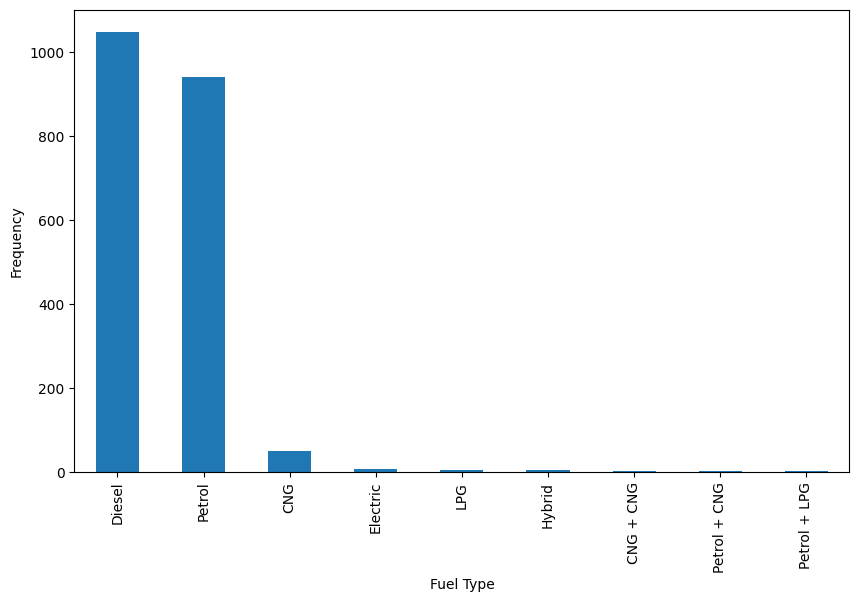

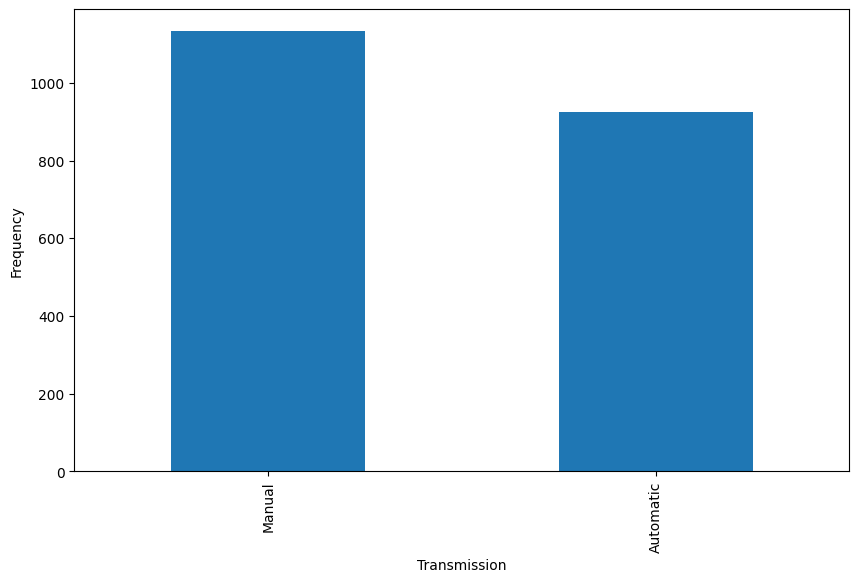

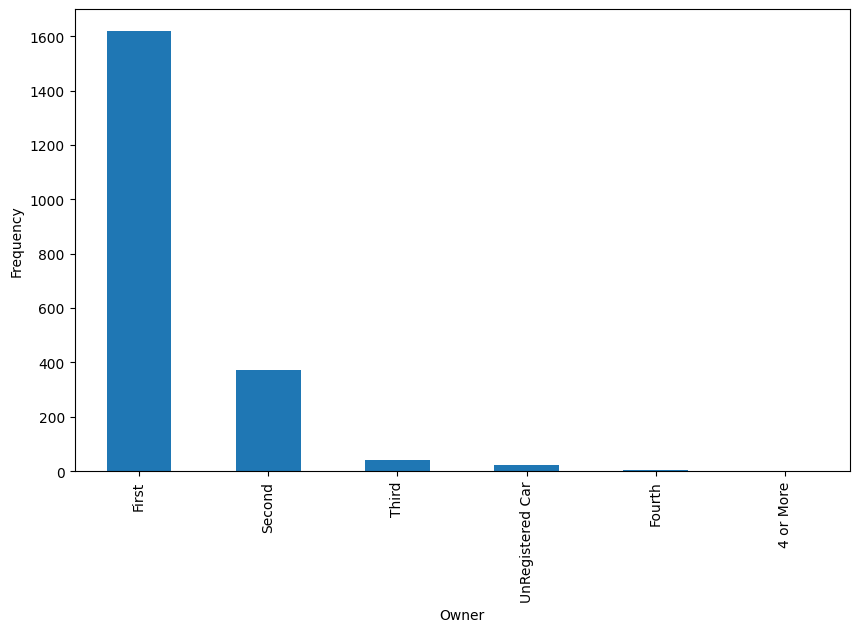

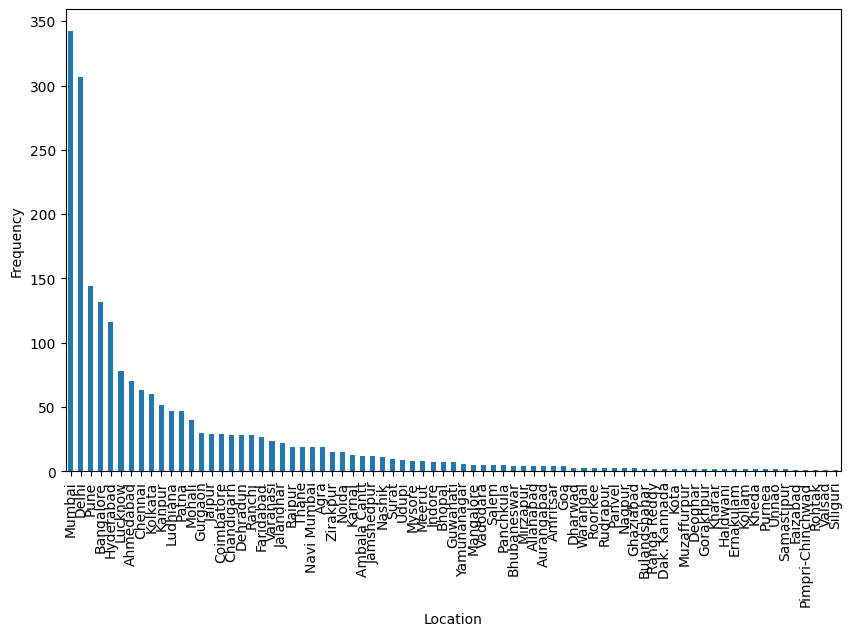

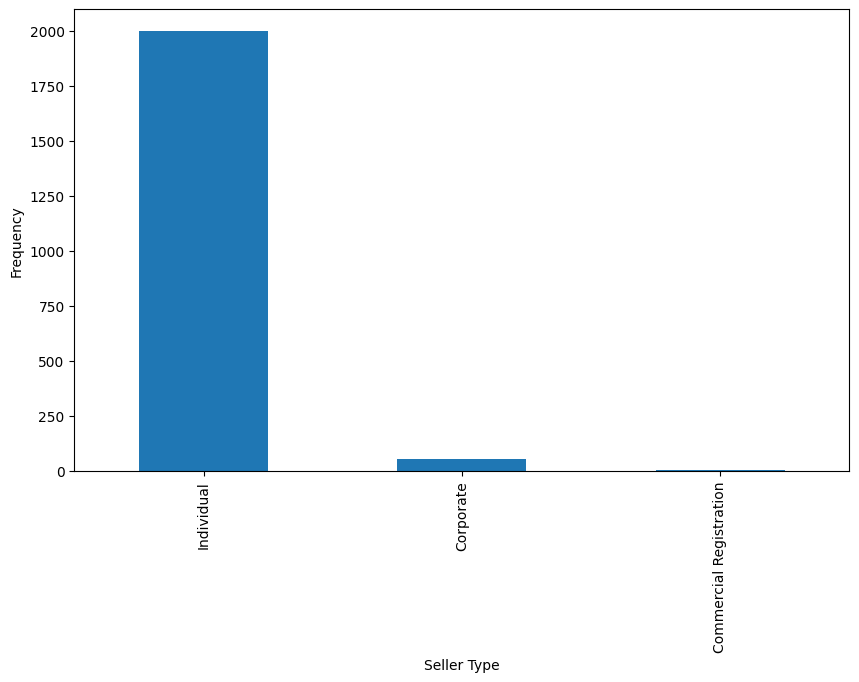

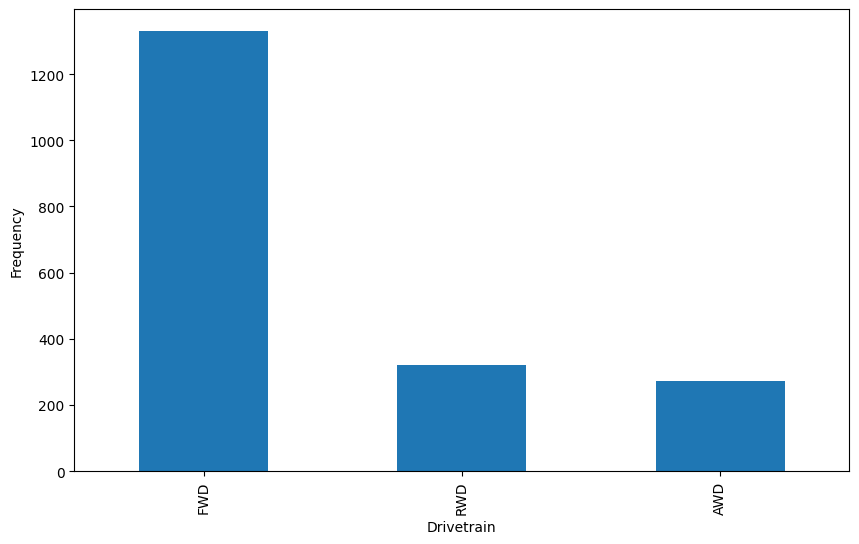

In [121]:
# for shake of simplicity I will cherrypick interesting columns, I want to see how balance is my dataset, such balance should be 
# check also in data monitoring before training
for col in ["Fuel Type", "Transmission", "Owner", "Location", "Seller Type", "Drivetrain"]:
    plot_hist(df, col) 

In [ ]:
# following changes are just for learning algorithm
# Fuel Type: I will merge all gas types to one. People dont distinguish between then. So alg will do same
# Owner: merge third and more to one as other, or I quess this is highly correlated with years.
# Location: this is big question for me (it depence on distance metric), I guess for model it will be distructing but for user not, 
# I will delete this one from training, but use in reranking.
# Seller Type: I wont use this, no information

In [122]:
# lets check scale regressors and their extreme values, just to see quantiles and extreme tell you a lot.
df.describe()

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm
count,2.059000e+03,2059.000000,2.059000e+03,1979.000000,1995.000000,1995.000000,1995.000000,1995.000000,1946.000000,1979.000000,1975.000000,1979.000000,1979.000000
mean,1.702992e+06,2016.425449,5.422471e+04,1692.575543,4280.860652,1767.991980,1591.735338,5.306266,52.002210,129.611774,4835.093671,245.851019,2619.545225
std,2.419881e+06,3.363564,5.736172e+04,643.736294,442.458507,135.265825,136.073956,0.822170,15.110198,65.073797,1097.368548,140.465731,1206.314770
min,4.900000e+04,1988.000000,0.000000e+00,624.000000,3099.000000,1475.000000,1165.000000,2.000000,15.000000,35.000000,2910.000000,48.000000,150.000000
25%,4.849990e+05,2014.000000,2.900000e+04,1197.000000,3985.000000,1695.000000,1485.000000,5.000000,41.250000,83.000000,4000.000000,115.000000,1600.000000
50%,8.250000e+05,2017.000000,5.000000e+04,1498.000000,4370.000000,1770.000000,1545.000000,5.000000,50.000000,116.000000,4200.000000,200.000000,1900.000000
75%,1.925000e+06,2019.000000,7.200000e+04,1995.000000,4629.000000,1831.500000,1675.000000,5.000000,60.000000,171.000000,6000.000000,350.000000,4000.000000
max,3.500000e+07,2022.000000,2.000000e+06,6592.000000,5569.000000,2220.000000,1995.000000,8.000000,105.000000,660.000000,8250.000000,780.000000,6500.000000


In [ ]:
# Kilometer: check 0 kilometer car if it not used, such unusual observations can tell as a lot about dataset and uncover interesting 
# patterns to check
# in general scale regressors looks balanced

In [123]:
df[df["Kilometer"] == 0] 
# its ok or not because its unregistered car, I propose check always this pattern

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,max_power_bhp,max_power_rpm,max_torque_nm,max_torque_rpm
1766,MINI,Cooper JCW Hatchback,5200000,2022,0,Petrol,Automatic,Ahmedabad,Yellow,UnRegistered Car,...,FWD,3850.0,1727.0,1414.0,4.0,44.0,228.0,5200.0,320.0,1450.0


# Conclusion

As I wrote, in general data looks balanced. I can also continue with checking if there is different correlations under subset by some categorical regressor etc. I stop here, because for model I plan to use its enough. I learned:

1. parse regressors what can tell as more if we play with them
2. group unbalanced categorical feature to be more informative for our task
3. check patterns I found, for ex. 0 km == unregistered (I bet my pants that there is more such patterns, but I have no time check everything). I dont like to delete unusual observations but for now I will close my eyes.
4. for training I will keep only `['Make', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Color', 'Engine', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity', 'max_power_bhp',
       'max_power_rpm', 'max_torque_nm', 'max_torque_rpm']` 

## notes
- missing values in engine cc will be imputed by mean so that means for leanring algorithm are all on same level and be in a middle of embedding space.
- I added unique id to dataset "item_id" for better navigation between items, this should be treated in proper way

## data to extra add
I will propose to our customer to add:
- images, we can use p-hash or some embedding model to embed images
- Same for text features as descriptions or more informative tile
- scrape some comparison web pages for rating and reviews (or star to collect own)